In [1]:
import pandas as pd
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/Users/likithsomashekar/Downloads/Project_Clone/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Load the datasets
coles_data = pd.read_csv('Coles_cleaned.csv')
updated_data = pd.read_csv('updated_recommendation_dataset.csv')

In [10]:
coles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20608 entries, 0 to 20607
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_code     20608 non-null  int64  
 1   category         20608 non-null  object 
 2   item_name        20608 non-null  object 
 3   best_price       20608 non-null  float64
 4   best_unit_price  20608 non-null  float64
 5   item_price       20608 non-null  float64
 6   unit_price       20608 non-null  float64
 7   link             20608 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.3+ MB


In [11]:
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       10000 non-null  int64 
 1   product_code  10000 non-null  int64 
 2   item_name     10000 non-null  object
 3   rating        10000 non-null  int64 
 4   category      10000 non-null  object
dtypes: int64(3), object(2)
memory usage: 390.8+ KB


In [ ]:
# Merge the two datasets on 'product_code' to associate user ratings with the product details
merged_data = pd.merge(updated_data, coles_data[['product_code', 'item_name', 'category']], on='product_code', how='inner')

In [12]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10823 entries, 0 to 10822
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       10823 non-null  int64 
 1   product_code  10823 non-null  int64 
 2   item_name_x   10823 non-null  object
 3   rating        10823 non-null  int64 
 4   category_x    10823 non-null  object
 5   item_name_y   10823 non-null  object
 6   category_y    10823 non-null  object
dtypes: int64(3), object(4)
memory usage: 592.0+ KB


In [13]:
# Group by 'product_code' to count the number of ratings per product
popular_products = pd.DataFrame(merged_data.groupby('product_code')['rating'].count())

# Sort the products by the number of ratings in descending order
most_popular = popular_products.sort_values('rating', ascending=False)

# Print the top 10 most rated products
print(most_popular.head(10))

              rating
product_code        
3984110           10
3081290            9
4737525            8
3984686            8
116220             8
8649077            8
5318969            8
3247291            8
8930039            8
6397723            8


Most rated item: Product ID 3984110 with 10 ratings


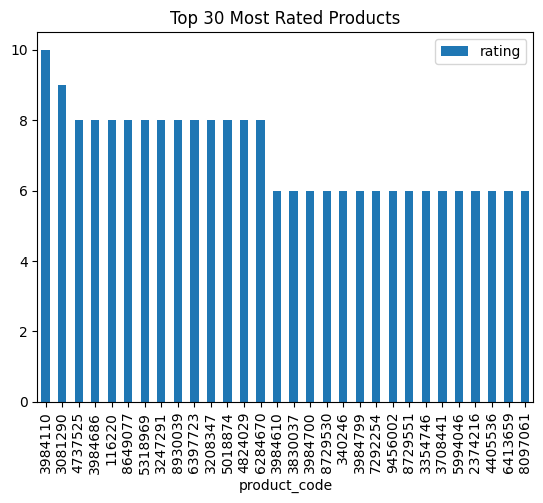

In [15]:
# Plot the top 30 most rated products
most_popular.head(30).plot(kind="bar", title="Top 30 Most Rated Products")

# Get the most rated item (Product with the highest number of ratings)
most_rated_item = most_popular.iloc[0]
# Print the details of the most rated item
print(f"Most rated item: Product ID {most_rated_item.name} with {most_rated_item['rating']} ratings")

### Analysis

- The above graph gives us the most rated products (arranged in descending order).

### Model-based collaborative filtering system
- Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.
- A model based collaborative filtering technique is closen here as it helps in making predictinfg products for a particular user by identifying patterns based on preferences from multiple user data.

In [16]:
# Create a utility matrix (user-item matrix)
utility_matrix = merged_data.pivot_table(index='user_id', columns='product_code', values='rating', aggfunc='mean')

# If a user hasn't rated a product, it's considered unrated)
utility_matrix = utility_matrix.fillna(0)

# Display the utility matrix
print(utility_matrix)

product_code  10693    13080    14639    25078    26139    31922    46883    \
user_id                                                                       
2                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   
8                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   
9                 0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10                0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...               ...      ...      ...      ...      ...      ...      ...   
992               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
993               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
994               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
997               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1000              0.0      0.0      0.0      0.0    

Utility Matrix : A utility matrix is a list of all the possible user item preferences or ratings which are arranged in the form of a matrix. This utility matrix is very sparse since it is highly unlikely that any of the users will purchase all the items in the list, so most of the values are unknown.

As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.

In [4]:
# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the product names from the merged dataset
def tokenize_product_names(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=64, return_tensors="tf")

# Tokenize the product names from the merged dataset
tokenized_inputs = tokenize_product_names(merged_data['item_name_x'])

In [5]:
# Prepare the labels (ratings)
ratings = np.array(merged_data['rating'])

# Split the data into training and validation sets (we'll keep the entire dataset for prediction)
X_train, X_val, y_train, y_val = train_test_split(tokenized_inputs['input_ids'].numpy(), ratings, test_size=0.2, random_state=42)

In [6]:
# Convert the tokenized data into TensorFlow tensors for training
train_inputs = {
    'input_ids': tf.convert_to_tensor(X_train),
    'attention_mask': tf.convert_to_tensor(tokenized_inputs['attention_mask'].numpy())[:len(X_train)]
}

val_inputs = {
    'input_ids': tf.convert_to_tensor(X_val),
    'attention_mask': tf.convert_to_tensor(tokenized_inputs['attention_mask'].numpy())[:len(X_val)]
}

# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, y_train))
train_dataset = train_dataset.batch(32).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, y_val))
val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Load the pre-trained DistilBERT model for sequence classification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

# Evaluate the model on the validation set
val_predictions = model.predict(val_dataset)
val_predictions = val_predictions[0]  # Get the predicted values

# Calculate the Mean Squared Error
mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {mse}")

# **Generate predictions for all items in merged_data**
# Predict ratings for all items in the merged_data
all_items = merged_data['item_name_x'].tolist()
tokenized_all_items = tokenizer(all_items, padding=True, truncation=True, max_length=64, return_tensors="tf")
predictions = model.predict(tokenized_all_items)

# Fix the dimensionality issue by flattening the predicted ratings
predicted_ratings = predictions[0].flatten()  # Flatten the predicted ratings array to make it 1D

# Ensure predictions match the number of products in the merged dataset
if len(predicted_ratings) != len(merged_data):
    raise ValueError(f"Predicted ratings length {len(predicted_ratings)} does not match dataset length {len(merged_data)}")

# Create the DataFrame with product details and predicted ratings
prediction_df = pd.DataFrame({
    'product_code': merged_data['product_code'],
    'item_name': merged_data['item_name_x'],
    'predicted_rating': predicted_ratings
})

# Display the DataFrame
print(prediction_df.head())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
271/271 [==============================] - 238s 857ms/step - loss: 2.1968 - mae: 1.2632 - val_loss: 1.9955 - val_mae: 1.2024
Epoch 2/3
271/271 [==============================] - 289s 1s/step - loss: 2.0362 - mae: 1.2292 - val_loss: 2.0057 - val_mae: 1.2125
Epoch 3/3
68/68 [==============================] - 19s 272ms/step
Validation MSE: 1.99266234039465
339/339 [==============================] - 100s 295ms/step
   product_code                                          item_name  \
0       4961223   Everblue Aspire Repair & Hydrate Shampoo | 400mL   
1       4494220  Modibodi Mid Rise Period Brief Moderate H ... ...   
2       6496361          Coco Earth Gummies Super Greens | 60 pack   
3       5300170          Rexona Antiperspirant Women Deo ... 220mL   
4       5782875             Maybelline Tattoo Liner Ink Pen | 6.3g   

   predicted_rating  
0          2.940104  
1          2.930335  
2          2.946054  
3          2.940455  
4          2.939698  


In [7]:
# Function to get top 5 recommendations for a customer based on a single input item
def get_top_recommendations_for_item(customer_id, input_item, model, tokenizer, merged_data, num_recommendations=5):
    # Tokenize the input item
    tokenized_input_item = tokenizer([input_item], padding=True, truncation=True, max_length=64, return_tensors="tf")

    # Predict ratings for all items
    all_items = merged_data['item_name_x'].tolist()
    tokenized_items = tokenizer(all_items, padding=True, truncation=True, max_length=64, return_tensors="tf")
    predictions = model.predict(tokenized_items)
    
    # Fix the dimensionality issue for predictions
    predicted_ratings = predictions[0].flatten()

    # Create a DataFrame with product details and predicted ratings
    prediction_df = pd.DataFrame({
        'product_code': merged_data['product_code'],
        'item_name': merged_data['item_name_x'],
        'predicted_rating': predicted_ratings
    })
    
    # Filter out items that the customer has already purchased (to avoid recommending the same item)
    customer_data = merged_data[merged_data['user_id'] == customer_id]
    purchased_items = customer_data['item_name_x'].tolist()
    prediction_df = prediction_df[~prediction_df['item_name'].isin(purchased_items)]

    # Sort items by predicted rating in descending order
    top_items = prediction_df.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
    
    # Print top 5 recommendations
    print(f"Top 5 Recommended Items for Customer {customer_id} based on '{input_item}':")
    print(top_items[['item_name', 'predicted_rating']])

In [8]:
customer_id = 974  # Example customer ID
input_item = 'Everblue Aspire Repair & Hydrate Shampoo | 400mL'  # Example input item
get_top_recommendations_for_item(customer_id, input_item, model, tokenizer, merged_data)

339/339 [==============================] - 79s 232ms/step
Top 5 Recommended Items for Customer 974 based on 'Everblue Aspire Repair & Hydrate Shampoo | 400mL':
                                              item_name  predicted_rating
2043  Aunt Betty's Saucy Centres Chocolate Twin Pack...          2.962824
2410  Aunt Betty's Saucy Centres Chocolate Twin Pack...          2.962824
922       Cadbury Twirl Caramilk Chocolate Bites | 130g          2.961491
1124          Coles Giant Pitted Kalamata Olives | 110g          2.961034
9380      Arnott's Savoy Crackers Cracked Pepper | 225g          2.960221
